<a href="https://colab.research.google.com/github/ylongresearch/COMP4107-ACV/blob/main/CAT2DOG_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("We're using =>", device)
!nvidia-smi

We're using => cuda
Thu Mar  3 13:16:06 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    34W / 250W |   1127MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                    

(50000, 32, 32, 3) uint8 (50000, 1) uint8
(1, 5000)
(1, 5000)


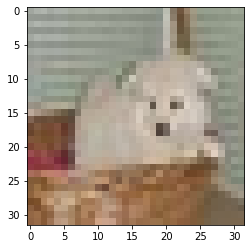

In [11]:
from keras.datasets import cifar10
(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()
print(X_train.shape, X_train.dtype, Y_train.shape, Y_train.dtype)
#########################
import numpy as np
import matplotlib.pyplot as plt
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

cat_idx = np.where(Y_train[:, 0] == 3)
dog_idx = np.where(Y_train[:, 0] == 5)
cat_idx_test = np.where(Y_test[:, 0] == 3)
dog_idx_test = np.where(Y_test[:, 0] == 5)

print(np.shape(cat_idx))
print(np.shape(dog_idx))
plt.imshow(X_train[dog_idx[0][4999]]) # visualise random images in range 0 to 4999
################################

cat_dog_idx = np.concatenate((cat_idx[0], dog_idx[0]))
cat_dog_idx_test = np.concatenate((cat_idx_test[0], dog_idx_test[0]))

cat_train = X_train[cat_idx]
dog_train = X_train[dog_idx]
cat_test = X_test[cat_idx_test]
dog_test = X_test[dog_idx_test]


cat_train = np.transpose(cat_train, (0,3,2,1))
dog_train = np.transpose(dog_train, (0,3,2,1))
cat_test = np.transpose(cat_test, (0,3,2,1))
dog_test = np.transpose(dog_test, (0,3,2,1))

In [12]:
!pip install albumentations==0.4.6

In [13]:
import torchvision
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2

transforms = A.Compose(
    [
        #A.Resize(width=256, height=256),
        A.HorizontalFlip(p=0.5),
        A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255),
        ToTensorV2(),
     ],
    additional_targets={"image0": "image"},
)

class PBdataset(Dataset):
    def __init__(self, X, Y, transform = None):

        self.X = torch.from_numpy(X)/255

        self.Y = torch.from_numpy(Y)/255
        # self.X = X
        # self.X = Y
        self.transform = transform

    def __getitem__(self, index):
        # X = self.transform(self.X[index])
        # Y = self.transform(self.Y[index])
        return self.X[index], self.Y[index]   # self.Y[index]

    def __len__(self):
        return len(self.X)


batch_size = 50
catdogTrainSet = PBdataset(cat_train,dog_train,transform=transforms)
catdogTrainLoader = torch.utils.data.DataLoader(catdogTrainSet, batch_size=batch_size, shuffle=True)
catdogTestSet = PBdataset(cat_test,dog_test,transform=transforms)
catdogTestLoader = torch.utils.data.DataLoader(catdogTestSet, batch_size=batch_size, shuffle=True)

In [14]:
import torch.nn as nn

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, down=True, use_act=True, **kwargs):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, padding_mode="reflect", **kwargs)
            if down
            else nn.ConvTranspose2d(in_channels, out_channels, **kwargs),
            nn.InstanceNorm2d(out_channels),
            nn.ReLU(inplace=True) if use_act else nn.Identity()
        )

    def forward(self, x):
        return self.conv(x)

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.block = nn.Sequential(
            ConvBlock(channels, channels, kernel_size=3, padding=1),
            ConvBlock(channels, channels, use_act=False, kernel_size=3, padding=1),
        )

    def forward(self, x):
        return x + self.block(x)

class Generator(nn.Module):
    def __init__(self, img_channels, num_features = 16, num_residuals=3):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(img_channels, num_features, kernel_size=7, stride=1, padding=3, padding_mode="reflect"),
            nn.InstanceNorm2d(num_features),
            nn.ReLU(inplace=True),
        )
        self.down_blocks = nn.ModuleList(
            [
                ConvBlock(num_features, num_features*2, kernel_size=3, stride=2, padding=1),
                ConvBlock(num_features*2, num_features*4, kernel_size=3, stride=2, padding=1),
            ]
        )
        self.res_blocks = nn.Sequential(
            *[ResidualBlock(num_features*4) for _ in range(num_residuals)]
        )
        self.up_blocks = nn.ModuleList(
            [
                ConvBlock(num_features*4, num_features*2, down=False, kernel_size=3, stride=2, padding=1, output_padding=1),
                ConvBlock(num_features*2, num_features*1, down=False, kernel_size=3, stride=2, padding=1, output_padding=1),
            ]
        )

        self.last = nn.Conv2d(num_features*1, img_channels, kernel_size=7, stride=1, padding=3, padding_mode="reflect")

    def forward(self, x):
        x = self.initial(x)
        for layer in self.down_blocks:
            x = layer(x)
        x = self.res_blocks(x)
        for layer in self.up_blocks:
            x = layer(x)
        return torch.tanh(self.last(x))


img_channels = 3
img_size = 30
x = torch.randn((12, img_channels, img_size, img_size))
gen = Generator(img_channels, 3)
print(gen(x).shape)

torch.Size([12, 3, 32, 32])


In [15]:
import torch.nn as nn

class Block(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 4, stride, 1, bias=True, padding_mode="reflect"),
            nn.InstanceNorm2d(out_channels),
            nn.LeakyReLU(0.2, inplace=True),
        )

    def forward(self, x):
        return self.conv(x)


class Discriminator(nn.Module):
    def __init__(self, in_channels=3, features=[32, 64]):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(
                in_channels,
                features[0],
                kernel_size=4,
                stride=2,
                padding=1,
                padding_mode="reflect",
            ),
            nn.LeakyReLU(0.2, inplace=True),
        )

        layers = []
        in_channels = features[0]
        for feature in features[1:]:
            layers.append(Block(in_channels, feature, stride=1 if feature==features[-1] else 2))
            in_channels = feature
        layers.append(nn.Conv2d(in_channels, 1, kernel_size=4, stride=1, padding=1, padding_mode="reflect"))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = self.initial(x)
        return torch.sigmoid(self.model(x))

x = torch.randn((5, 3, 30, 30))
model = Discriminator(in_channels=3)
preds = model(x)
print(preds.shape)

torch.Size([5, 1, 13, 13])


In [16]:
import torch
import sys
import torch.optim as optim
from tqdm import tqdm
from torchvision.utils import save_image

LEARNING_RATE = 1e-5
LAMBDA_IDENTITY = 0.0
LAMBDA_CYCLE = 10
NUM_EPOCHS = 10
SAVE_MODEL = False
def train_fn(disc_H, disc_Z, gen_Z, gen_H, loader, opt_disc, opt_gen, l1, mse, d_scaler, g_scaler):
    H_reals = 0
    H_fakes = 0
    loop = tqdm(loader, leave=True)

    for idx, (cat, dog) in enumerate(loop):
        cat = cat.to(device)
        dog = dog.to(device)

        # Train Discriminators H and Z
        with torch.cuda.amp.autocast():
            fake_dog = gen_H(cat)
            D_H_real = disc_H(dog)
            D_H_fake = disc_H(fake_dog.detach())
            H_reals += D_H_real.mean().item()
            H_fakes += D_H_fake.mean().item()
            D_H_real_loss = mse(D_H_real, torch.ones_like(D_H_real))
            D_H_fake_loss = mse(D_H_fake, torch.zeros_like(D_H_fake))
            D_H_loss = D_H_real_loss + D_H_fake_loss

            fake_cat = gen_Z(dog)
            D_Z_real = disc_Z(cat)
            D_Z_fake = disc_Z(fake_cat.detach())
            D_Z_real_loss = mse(D_Z_real, torch.ones_like(D_Z_real))
            D_Z_fake_loss = mse(D_Z_fake, torch.zeros_like(D_Z_fake))
            D_Z_loss = D_Z_real_loss + D_Z_fake_loss

            # put it togethor
            D_loss = (D_H_loss + D_Z_loss)/2

        opt_disc.zero_grad()
        d_scaler.scale(D_loss).backward()
        d_scaler.step(opt_disc)
        d_scaler.update()

        # Train Generators H and Z
        with torch.cuda.amp.autocast():
            # adversarial loss for both generators
            D_H_fake = disc_H(fake_dog)
            D_Z_fake = disc_Z(fake_cat)
            loss_G_H = mse(D_H_fake, torch.ones_like(D_H_fake))
            loss_G_Z = mse(D_Z_fake, torch.ones_like(D_Z_fake))

            # cycle loss
            cycle_cat = gen_Z(fake_dog)
            cycle_dog = gen_H(fake_cat)
            cycle_cat_loss = l1(cat, cycle_cat)
            cycle_dog_loss = l1(dog, cycle_dog)

            # identity loss (remove these for efficiency if you set lambda_identity=0)
            identity_cat = gen_Z(cat)
            identity_dog = gen_H(dog)
            identity_cat_loss = l1(cat, identity_cat)
            identity_dog_loss = l1(dog, identity_dog)

            # add all togethor
            G_loss = (
                loss_G_Z
                + loss_G_H
                + cycle_cat_loss * LAMBDA_CYCLE
                + cycle_dog_loss * LAMBDA_CYCLE
                + identity_dog_loss * LAMBDA_IDENTITY
                + identity_cat_loss * LAMBDA_IDENTITY
            )

        opt_gen.zero_grad()
        g_scaler.scale(G_loss).backward()
        g_scaler.step(opt_gen)
        g_scaler.update()

        if idx % 20 == 0:
            save_image(fake_dog*0.5+0.5, f"./saved_images/dog_{idx}.png")
            save_image(fake_cat*0.5+0.5, f"./saved_images/cat_{idx}.png")

        loop.set_postfix(H_real=H_reals/(idx+1), H_fake=H_fakes/(idx+1))

In [17]:
!mkdir saved_images

mkdir: cannot create directory ‘saved_images’: File exists


In [18]:
def main():
    disc_H = Discriminator(in_channels=3).to(device)
    disc_Z = Discriminator(in_channels=3).to(device)
    gen_Z = Generator(img_channels=3, num_residuals=4).to(device)
    gen_H = Generator(img_channels=3, num_residuals=4).to(device)
    opt_disc = optim.Adam(
        list(disc_H.parameters()) + list(disc_Z.parameters()),
        lr=LEARNING_RATE,
        betas=(0.5, 0.999),
    )

    opt_gen = optim.Adam(
        list(gen_Z.parameters()) + list(gen_H.parameters()),
        lr=LEARNING_RATE,
        betas=(0.5, 0.999),
    )

    L1 = nn.L1Loss()
    mse = nn.MSELoss()


    g_scaler = torch.cuda.amp.GradScaler()
    d_scaler = torch.cuda.amp.GradScaler()

    for epoch in range(NUM_EPOCHS):
        train_fn(disc_H, disc_Z, gen_Z, gen_H, catdogTrainLoader, opt_disc, opt_gen, L1, mse, d_scaler, g_scaler)

if __name__ == "__main__":
    main()

100%|██████████| 100/100 [00:11<00:00,  8.52it/s, H_fake=0.473, H_real=0.524]
